## Image Classification using Convolutional Neural Networks

### Splitting the training, validation, and test data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from random import randint

data_dir = "yoga32"
train_batch_size = 32
rand_seed = randint(0, 1e9) # random seed for training/validation split, to prevent them overlapping

# Set 80% of the data in the train directory to be training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+'/train',
    validation_split=0.2,
    subset="training",
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

# Set the other 20% to be validation data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+'/train',
    validation_split=0.2,
    subset="validation",
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

print(train_data.class_names)

Found 520 files belonging to 10 classes.
Using 416 files for training.
Found 520 files belonging to 10 classes.
Using 104 files for validation.
['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


### Initial CNN
A CNN with 9 layers: the input layer, a normalisation layer, two convolutional layers, a max pool layer, another two convolutional, and another maxpool, which is then flattened and fed into a dense output layer.

In [2]:
norm_layer = tf.keras.layers.Rescaling(1./255) # normalise from 0-255 to 0-1
cnn = keras.Sequential(
    [
        # Input and normalization
        layers.Input((32, 32, 3)),
        norm_layer,
        # First convolutions and maxpool
        layers.Conv2D(16, (3, 3), activation='relu', padding="valid",strides=(1, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding="valid",strides=(1, 1)),
        layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"),
        # 2nd convolutions and maxpool
        layers.Conv2D(24, (3, 3), activation='relu', padding="valid",strides=(1, 1)),
        layers.Conv2D(24, (3, 3), activation='relu', padding="valid",strides=(1, 1)),
        layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"),
        # Fully connected layer
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ], 
)

cnn.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])
# Fit model
history_cnn = cnn.fit(train_data, validation_data=val_data, epochs=40)

Epoch 1/40
13/13 [==============================] - 0s 17ms/step - loss: 2.3059 - accuracy: 0.1058 - val_loss: 2.3084 - val_accuracy: 0.0673
Epoch 2/40
13/13 [==============================] - 0s 11ms/step - loss: 2.2820 - accuracy: 0.1274 - val_loss: 2.2865 - val_accuracy: 0.1346
Epoch 3/40
13/13 [==============================] - 0s 11ms/step - loss: 2.2430 - accuracy: 0.1827 - val_loss: 2.2569 - val_accuracy: 0.1058
Epoch 4/40
13/13 [==============================] - 0s 11ms/step - loss: 2.1362 - accuracy: 0.2163 - val_loss: 2.1233 - val_accuracy: 0.1923
Epoch 5/40
13/13 [==============================] - 0s 11ms/step - loss: 1.9043 - accuracy: 0.3293 - val_loss: 1.8625 - val_accuracy: 0.2692
Epoch 6/40
13/13 [==============================] - 0s 11ms/step - loss: 1.7107 - accuracy: 0.4087 - val_loss: 1.7443 - val_accuracy: 0.3558
Epoch 7/40
13/13 [==============================] - 0s 11ms/step - loss: 1.5545 - accuracy: 0.4688 - val_loss: 1.7239 - val_accuracy: 0.3654
Epoch 8/40
13

As is visible in the training output and the plot below, the training and validation accuracy both rise steadily over the epochs. However, around epochs 5-9, the training and validation sets accuracies diverge, with the training accuracy continuing to increase and the validation accuracy fluctuating around 0.5. This is evidence that past this point, the increase in training accuracy can be attributed to overfitting rather than an actual performance increase.

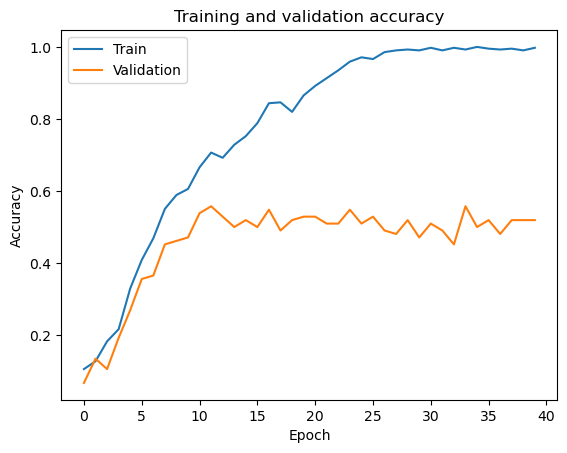

In [3]:
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### CNN with added dropout
This CNN is the same as the first, except a 60% dropout layer is added before the output layer to prevent the network from overfitting. By randomly setting 60% of the weights to the output layer to 0 during training, the network cannot rely too heavily on a handful of nodes, and must learn more general patterns from the data.

In [12]:
norm_layer = tf.keras.layers.Rescaling(1./255)
cnn_drop = keras.Sequential(
    [
        # Input and normalization
        layers.Input((32, 32, 3)),
        norm_layer,
        # First convolutions and maxpool
        layers.Conv2D(16, (3, 3), activation='relu',
                      padding="valid", strides=(1, 1)),
        layers.Conv2D(16, (3, 3), activation='relu',
                      padding="valid", strides=(1, 1)),
        layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"),
        # 2nd convolutions and maxpool
        layers.Conv2D(24, (3, 3), activation='relu',
                      padding="valid", strides=(1, 1)),
        layers.Conv2D(24, (3, 3), activation='relu',
                      padding="valid", strides=(1, 1)),
        layers.MaxPooling2D((2, 2), strides=(2, 2), padding="valid"),
        # Fully connected layer + dropout
        layers.Flatten(),
        tf.keras.layers.Dropout(0.6),
        layers.Dense(10, activation='softmax')
    ],
)
cnn_drop.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])
# Fit model
history_cnn_drop = cnn_drop.fit(train_data, validation_data=val_data, epochs=40)

Epoch 1/40
13/13 [==============================] - 0s 16ms/step - loss: 2.3066 - accuracy: 0.1082 - val_loss: 2.2946 - val_accuracy: 0.1154
Epoch 2/40
13/13 [==============================] - 0s 11ms/step - loss: 2.3019 - accuracy: 0.1106 - val_loss: 2.2996 - val_accuracy: 0.1154
Epoch 3/40
13/13 [==============================] - 0s 11ms/step - loss: 2.3006 - accuracy: 0.1274 - val_loss: 2.2963 - val_accuracy: 0.0962
Epoch 4/40
13/13 [==============================] - 0s 11ms/step - loss: 2.2865 - accuracy: 0.1538 - val_loss: 2.2803 - val_accuracy: 0.2212
Epoch 5/40
13/13 [==============================] - 0s 13ms/step - loss: 2.2670 - accuracy: 0.1490 - val_loss: 2.2551 - val_accuracy: 0.2308
Epoch 6/40
13/13 [==============================] - 0s 11ms/step - loss: 2.2213 - accuracy: 0.2139 - val_loss: 2.1796 - val_accuracy: 0.2596
Epoch 7/40
13/13 [==============================] - 0s 11ms/step - loss: 2.1359 - accuracy: 0.2500 - val_loss: 2.0180 - val_accuracy: 0.3077
Epoch 8/40
13

As is visible from the below plot, by adding dropout, the training and validation accuracies diverge far less. The validation accuracy also improves from ~50% in the base model to ~65% in the model with dropout, a significant improvement.

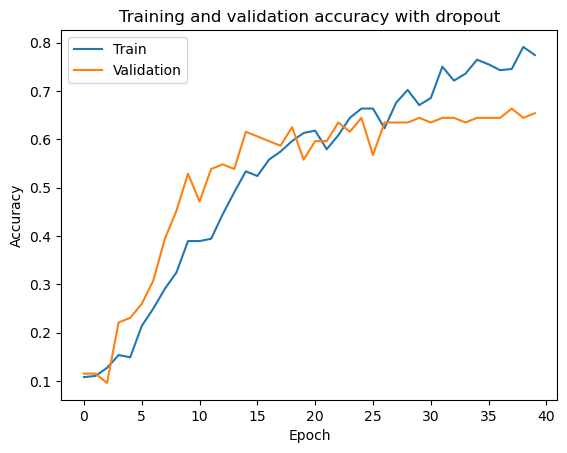

In [13]:
plt.plot(history_cnn_drop.history['accuracy'], label='Train')
plt.plot(history_cnn_drop.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validation accuracy with dropout')
plt.legend()
plt.show()

### Error anaylsis

In [14]:
# Get the test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+'/test',
    image_size=(32, 32))

Found 70 files belonging to 10 classes.


In [21]:
# Get the x, y pairs from the test data
# This is necessary to prevent the data shuffling every time it's accessed
test = [(x, y) for x, y in test_data]
# get the names
test_classes = test_data.class_names
test_classes

['bridge',
 'childs',
 'downwarddog',
 'mountain',
 'plank',
 'seatedforwardbend',
 'tree',
 'trianglepose',
 'warrior1',
 'warrior2']

Get all the ground truths and predictions

In [16]:
# Input images
test_input = np.concatenate([x for x, y in test])
# Labels for the images
ground_truth = np.concatenate([y for x, y in test])

In [17]:
# Models predicted labels
predicted = np.argmax(cnn_drop.predict(test_input), axis=-1)
predicted

3/3 [==============================] - 0s 2ms/step


array([5, 6, 2, 2, 8, 2, 7, 7, 4, 0, 4, 3, 6, 1, 5, 8, 1, 5, 3, 2, 8, 1,
       3, 5, 9, 5, 0, 7, 9, 3, 3, 6, 1, 1, 1, 5, 7, 6, 3, 4, 0, 7, 7, 1,
       1, 6, 2, 2, 3, 3, 6, 1, 2, 0, 7, 4, 9, 3, 8, 3, 0, 9, 9, 8, 8, 6,
       9, 1, 4, 3])

In [18]:
# Get the overall accuracy
round(sum(ground_truth==predicted)/len(ground_truth),2)

0.5

In [19]:
# Count the correct predictions
counts = {x:0 for x in range(10)}
totals = {x:0 for x in range(10)}
for actual, pred in zip(ground_truth, predicted):
    counts[actual] += pred==actual
    totals[actual] += 1
# Convert them to accuracies
accuracies = {test_classes[label]:round(counts[label]/totals[label],2) for label in counts}
accuracies

{'bridge': 0.43,
 'childs': 0.71,
 'downwarddog': 0.57,
 'mountain': 1.0,
 'plank': 0.14,
 'seatedforwardbend': 0.29,
 'tree': 0.29,
 'trianglepose': 0.43,
 'warrior1': 0.43,
 'warrior2': 0.71}

The model struggles with the seated forward bend, plank, and tree classes in particular

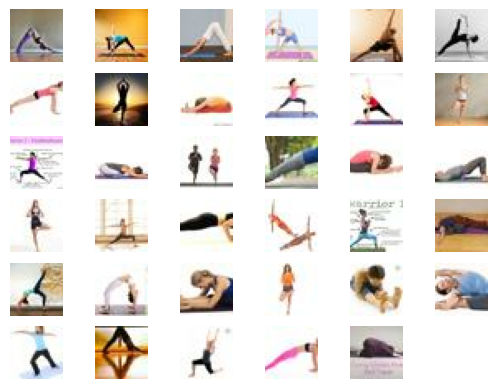

In [20]:
# Display all of the images that the model misclassified
failed = ground_truth[predicted!=ground_truth]
failed_pred = predicted[predicted!=ground_truth]
failed_input = test_input[predicted!=ground_truth]
square = math.ceil(np.sqrt(len(failed)))
# Images the model failed on
for i in range(len(failed)):
    plt.subplot(square,square,i+1)
    plt.axis('off')
    plt.imshow(failed_input[i]/255)
plt.show()

To get a better idea of why the plank class might cause the model so much trouble, we check the plank images it misclassified.

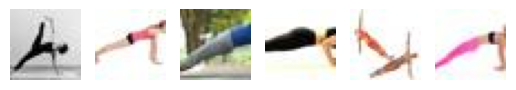

In [23]:
plank_fails = failed[failed==4]
plank_input = failed_input[failed==4]
for i in range(len(plank_fails)):
    plt.subplot(1,len(plank_fails),i+1)
    plt.axis('off')
    plt.imshow(plank_input[i]/255)
    

These images all have strange aspects that make it understandable for the model to fail on them. In the first, the model is raising their leg, in the third and fourth the image is zoomed in, in the fifth there are two models with spread arms, and in the last the model is facing upwards. Given the diversity in images, it is understandable the model couldn't learn to classify this excercise with the small dataset available.

### Visualisation
In this section, we attempt to visualise the feature space of the model by gathering the five most similar images in the training set, for any image in the test set, according the the model we've built.

In [24]:
# Get the layers from the cnn with dropout
for i in range(len(cnn_drop.layers)):
    layer = cnn_drop.layers[i]
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 rescaling_5 (None, 32, 32, 3)
1 conv2d_20 (None, 30, 30, 16)
2 conv2d_21 (None, 28, 28, 16)
3 max_pooling2d_10 (None, 14, 14, 16)
4 conv2d_22 (None, 12, 12, 24)
5 conv2d_23 (None, 10, 10, 24)
6 max_pooling2d_11 (None, 5, 5, 24)
7 flatten_5 (None, 600)
8 dropout_4 (None, 600)
9 dense_5 (None, 10)


In [27]:
model = Model(inputs=cnn_drop.inputs, outputs=cnn_drop.layers[7].output)

In [28]:
from scipy.spatial import distance

In [31]:
# Stop shuffling ocurring
train = [(x, y) for x, y in train_data]
train_input = np.concatenate([x for x, y in train])
# Feature vector of training data
train_vectors = model.predict(train_input)
test_vectors = model.predict(test_input)
def get_5_NN(index):
    """
    Given an index in the test set, get its five nearest neighbours in the training set
    """
    # Get the image's feature vector
    image_vector = test_vectors[index]
    # Get the distances
    distances = [distance.euclidean(train_vec.flatten(), image_vector.flatten()) for train_vec in train_vectors]
    # Find the five closest training images
    indices = np.argpartition(distances, 5)[:5]
    result = train_input[indices]
    return result

3/3 [==============================] - 0s 2ms/step


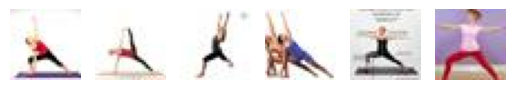

In [32]:
# Change to get different test images
INDEX = 20
# Plot the test image
plt.subplot(1,6,1)
plt.axis("off")
plt.imshow(test_input[INDEX]/255)
# Plot the 5 NN in training set
neighbours = get_5_NN(INDEX)
for i in range(5):
    plt.subplot(1,6,i+2)
    plt.axis('off')
    plt.imshow(neighbours[i]/255)

From the above example, it can be seen that the model has captured the pattern of a personm with their legs spread and their left knee bent. The second image does not have this exact pose, but he left arm and left leg form a similar shape, which the model has likely captured due to the original model's arm being in the same position.